In [34]:
%load_ext autoreload
%autoreload 2
import json 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn
import warnings

from functools import reduce
from IPython.display import display, HTML
from musk.core.sql import MySQL
from musk.core.plot import Plot
from pandas import DataFrame
from scipy.optimize import curve_fit    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:

FIGURE_QUALITY_MAP = {
    1: dict(figsize=(8, 6), dpi=120), # Publication
    2: dict(figsize=(10, 8), dpi=135), # Visualization
    3: dict(figsize=(16, 9), dpi=250),
}
seaborn.set()
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rc("xtick", labelsize="x-small")
plt.rc("ytick", labelsize="x-small")


In [36]:
N_BINS = 10000

ID_COL = "id"
PROBABILITY_COL = "probability"
SIZE_COL = "size"
HAS_PERCOLATED_COL = "has_percolated"
CLUSTER_SIZE_HIST_COL = "cluster_size_histogram"
MEAN_CLUSTER_SIZE_COL = "mean_cluster_size"
CORRELATION_FUNCTION_COL = "correlation_function"
PERC_CLUSTER_STRENGTH_COL = "percolating_cluster_strength"



In [37]:
def sum_dict(x,y):
    return {
        index: x.get(str(index), 0) + y.get(str(index), 0) 
        for index in list(x.keys()) + list(y.keys())
    }

def load_json(json_as_str):
        return json.loads(json_as_str)

def get_average_dict_distribution(df, col_name):
    n_observations = df.shape[0]
    # Map distributions from STR to JSONii

    df = df[col_name].map(load_json)
    # Sum elements values associated with same keys
    total_dist = reduce(
        lambda x,y: sum_dict(x, y), 
        df.tolist()
    )

    # Convert keys to ints 
    total_dist = {int(key): value for key, value in total_dist.items()}
    
    X = np.array(list(total_dist.keys()))
    Y = np.array(list(total_dist.values()))
    
    # Sort X (and Y in an equivalent fashion) in ascending order
    argsort = np.argsort(X)
    X = X[argsort]
    Y = Y[argsort]    
    
    # Divide by number of observations to get average
    Y = Y / n_observations
    return X, Y 


def setup_figure():
    quality = 2
    return plt.figure(**FIGURE_QUALITY_MAP[quality])

def filter_and_select_columns(df_, sizes, probabilities, columns):
    df = df_
    if sizes:
        size_filter = df[SIZE_COL].isin(sizes)
        df = df.loc[size_filter]
    if probabilities:
        
        probability_filter = df_orig[PROBABILITY_COL].isin(probabilities)
        df = df.loc[probability_filter]
    
    select_columns = [ID_COL, PROBABILITY_COL, SIZE_COL] + columns
    df = df[select_columns]
    df = df.dropna()    
    
    return df 


def select_probabilities_in_range(df, prob_range=None, level=None):
    probabilities = df[PROBABILITY_COL].unique()
    if prob_range:
        lower_bound, upper_bound = prob_range
        
        probabilities = probabilities[np.where(
            (probabilities >= lower_bound) & (probabilities <= upper_bound)
        )]
    if level:
        probabilities = probabilities[np.where(
            np.round(probabilities, level) == probabilities
        )]
    
    return probabilities.tolist()
    

In [38]:
query = "SELECT * FROM percolation_2d_square_stats"
mysql = MySQL()
rows = mysql.fetch(query)
df_orig = DataFrame.from_records(rows)


### Percolation probability

#### General data plot

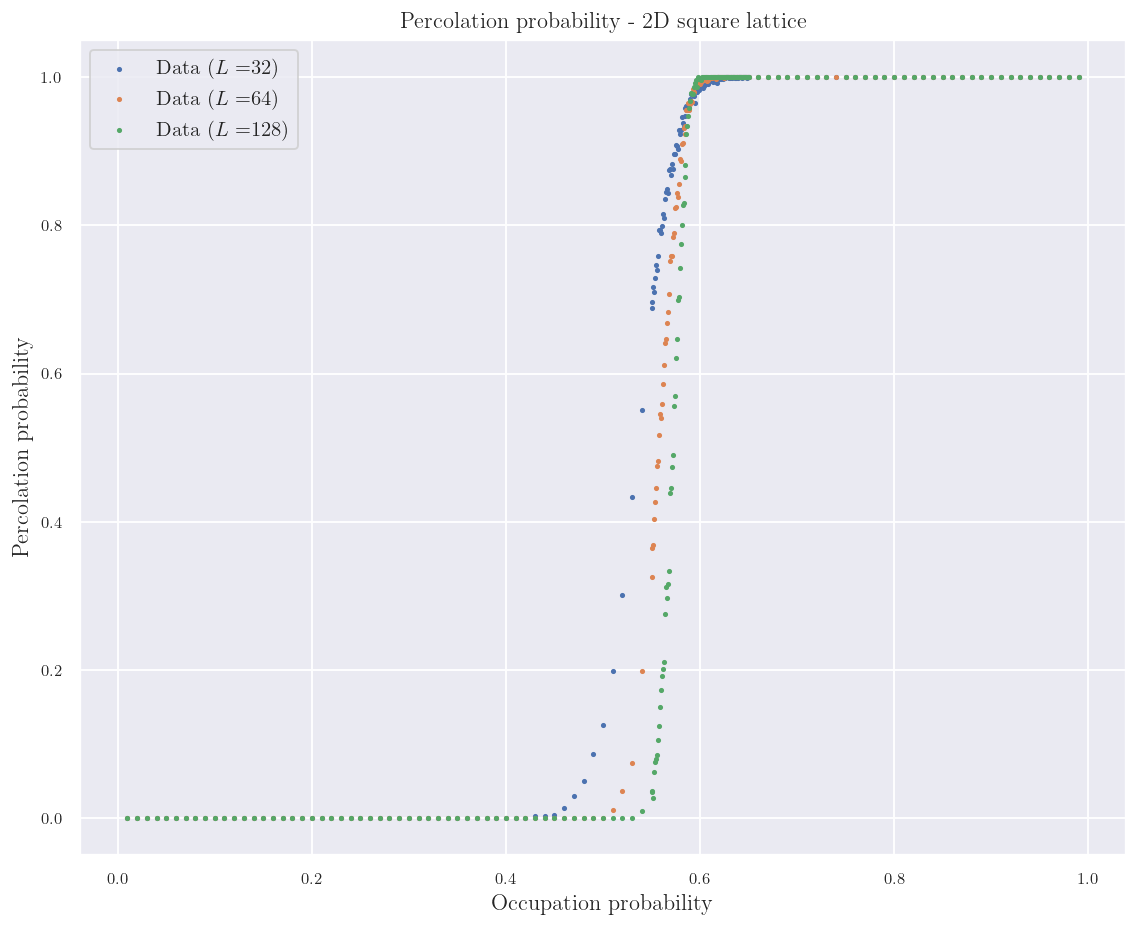

In [70]:
sizes = [32, 64, 128, 512]
probabilities = []
df = filter_and_select_columns(df_orig, sizes, probabilities, [HAS_PERCOLATED_COL])
setup_figure()

for size, group_df in df.groupby(SIZE_COL):
    group_df = group_df.groupby(PROBABILITY_COL)[HAS_PERCOLATED_COL].mean()
    plt.scatter(group_df.index, group_df, s=3, label=f"Data ($L=${size})")

plt.title("Percolation probability - 2D square lattice")
plt.xlabel("Occupation probability")
plt.ylabel("Percolation probability")
plt.legend()
plt.show()


#### Smaller range plot, with tanh fit

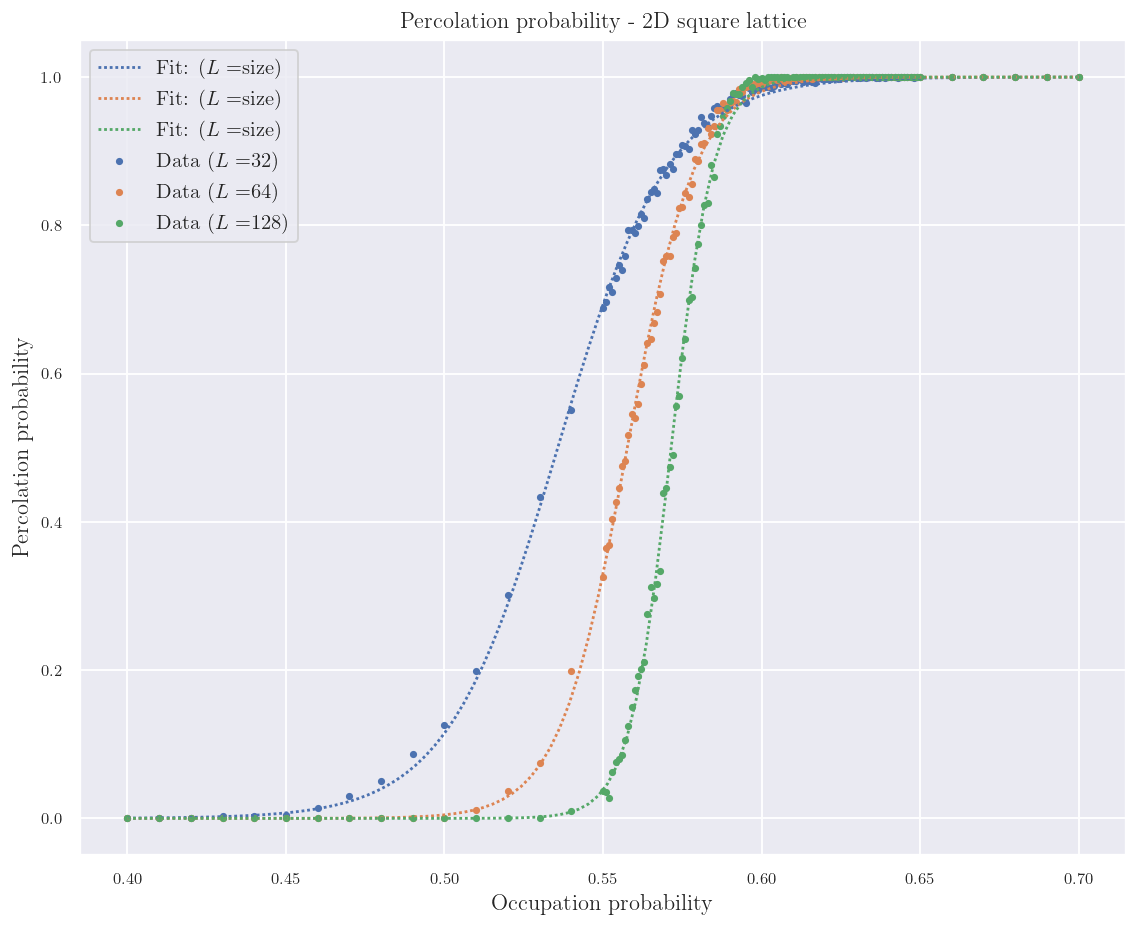

In [41]:
def fit_fn(X, a, b):
    return 0.5 * np.tanh(a*(X - b)) + 0.5

sizes = [32, 64, 128]
prob_range = [0.4, 0.7]
probabilities = select_probabilities_in_range(df_orig, prob_range, 3)
df = filter_and_select_columns(df_orig, sizes, probabilities, [HAS_PERCOLATED_COL])
setup_figure()

for size, group_df in df.groupby(SIZE_COL):
    group_df = group_df.groupby(PROBABILITY_COL)[HAS_PERCOLATED_COL]
    mean = group_df.mean()
    X, Y = mean.index, mean
    popt = (10, 0.59)
    popt, pcov = curve_fit(fit_fn, X, Y, p0=popt)
    plt.scatter(X, Y, s=8, label=f"Data ($L=${size})")
    X_fit = np.linspace(min(X), max(X), 100)
    plt.plot(X_fit, fit_fn(X_fit, *popt), "--", dashes=(1, 1), label="Fit: ($L=${size})")

plt.title("Percolation probability - 2D square lattice")
plt.xlabel("Occupation probability")
plt.ylabel("Percolation probability")
plt.legend()
plt.show()


### Parameter scaling

[ 2.86366597 -1.34963978  0.67693702]
0.5419923756596985


<Figure size 1350x1080 with 0 Axes>

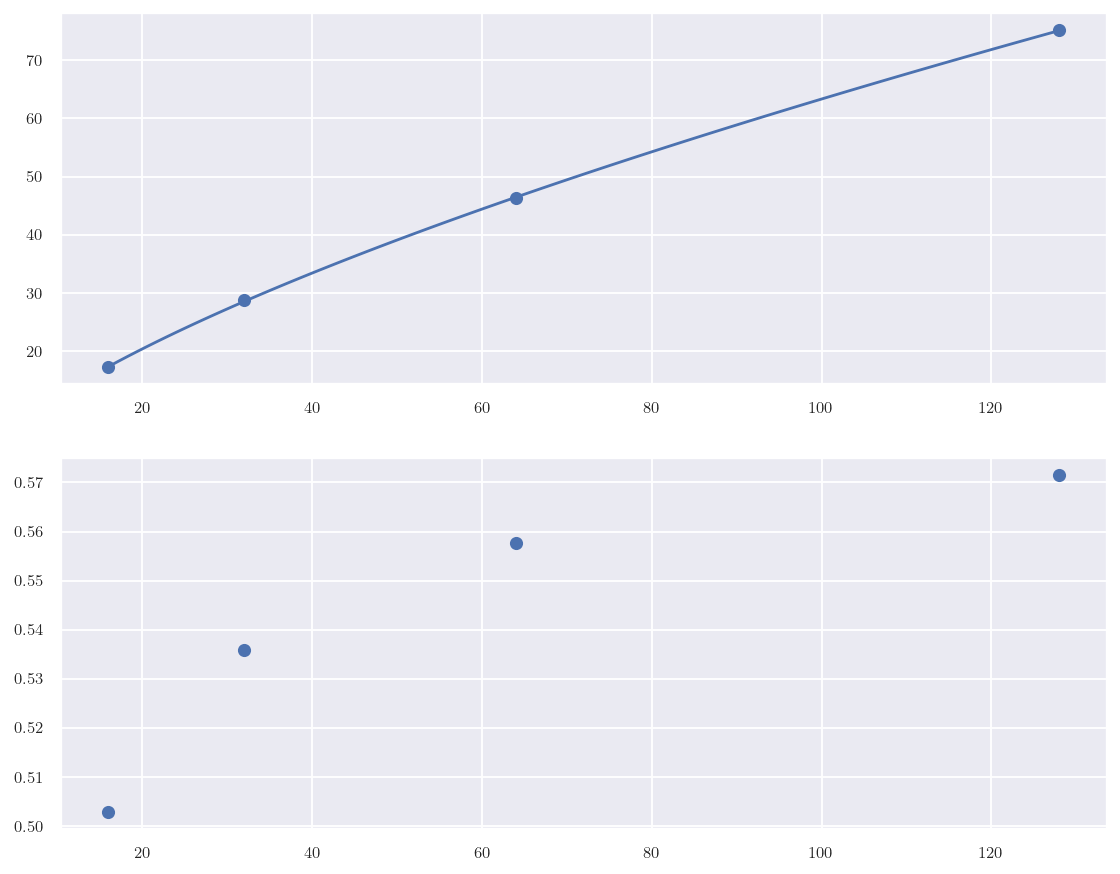

In [42]:
def fit_fn(X, a, b):
    return 0.5 * np.tanh(a*(X - b)) + 0.5

def log_fit_fn(X, a, b, n):
    return a*X**n + b

sizes = [16, 32, 64, 96, 128, 256]
sizes = []
prob_range = [0.5, 0.7]
probabilities = select_probabilities_in_range(df_orig, prob_range, 3)
probabilitites = []
df = filter_and_select_columns(df_orig, sizes, probabilities, [HAS_PERCOLATED_COL])
setup_figure()

parameters = {
    "α": [], 
    "β": []
}
sizes = []

for size, group_df in df.groupby(SIZE_COL):
    group_df = group_df.groupby(PROBABILITY_COL)[HAS_PERCOLATED_COL]
    mean = group_df.mean()
    X, Y = mean.index, mean
    popt = (10, 0.59)
    popt, pcov = curve_fit(fit_fn, X, Y, p0=popt)
    sizes.append(size)
    parameters["α"].append(popt[0])
    parameters["β"].append(popt[1])
    
fig, (ax1, ax2) = plt.subplots(2, **FIGURE_QUALITY_MAP[2])
popt, pcov = curve_fit(log_fit_fn, sizes, parameters["α"])
print(popt)
ax1.scatter(sizes, parameters["α"])
X_fit = np.linspace(min(sizes), max(sizes), 100)
ax1.plot(X_fit, log_fit_fn(X_fit, *popt))
ax2.scatter(sizes, parameters["β"])
# plt.title("Percolation probability - 2D square lattice")
# plt.xlabel("Occupation probability")
# plt.ylabel("Percolation probability")
# plt.legend()
print(sum(parameters["β"])/len(parameters["β"]))
plt.show()

### Mean cluster size


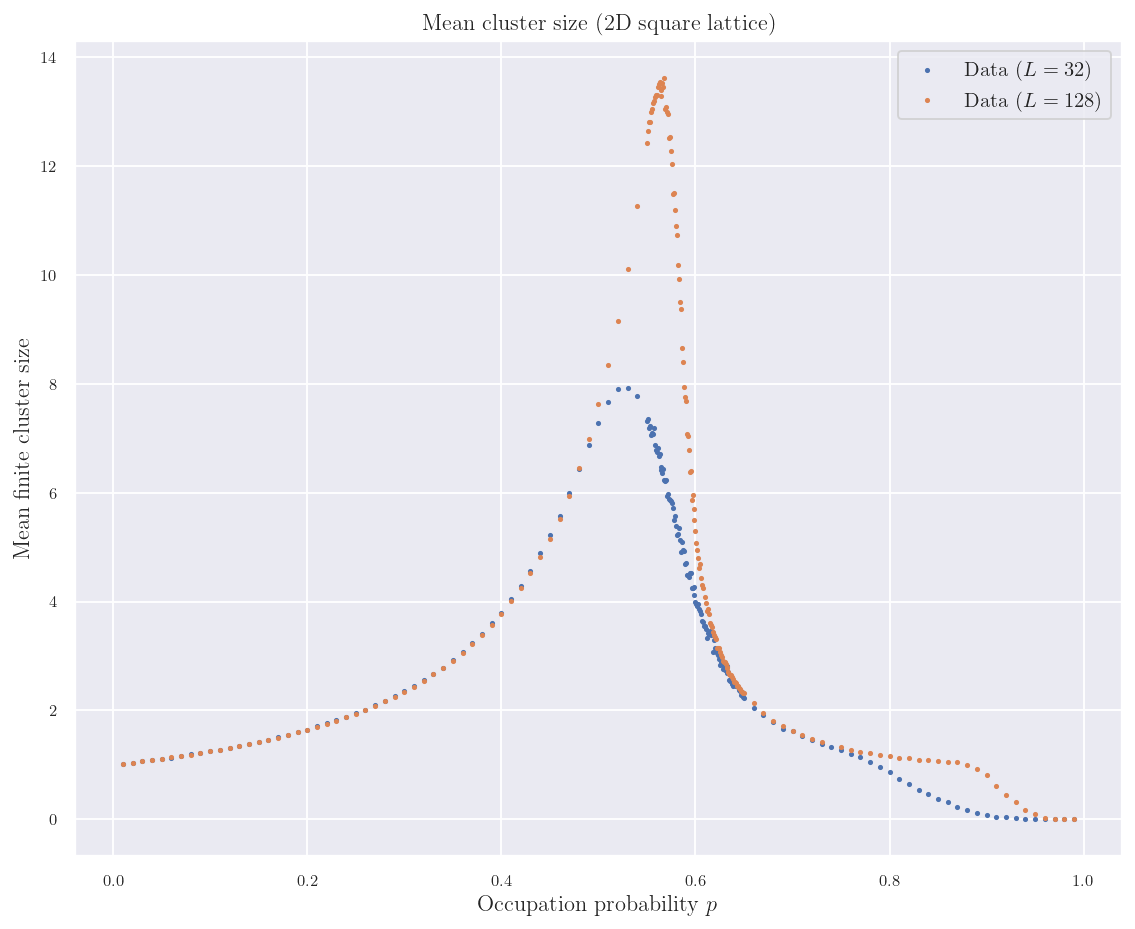

In [43]:
def fit_fn(X, a, b, c):
    return a * np.exp(b*X) + c

sizes = [32, 128, 256, 512]
probabilities = []
df = filter_and_select_columns(df_orig, sizes, probabilities, [MEAN_CLUSTER_SIZE_COL])
setup_figure()

for size, group_df in df.groupby(SIZE_COL):
    group_df = group_df.groupby(PROBABILITY_COL)[MEAN_CLUSTER_SIZE_COL].mean()
    X, Y = group_df.index, group_df
    plt.scatter(X, Y, s=3, label=f"Data ($L={size}$)")
    
    

plt.title("Mean cluster size (2D square lattice)")
plt.xlabel("Occupation probability $p$")
plt.ylabel("Mean finite cluster size")
plt.legend()
plt.show()



### Cluster size distribution

### Percolating cluster strength

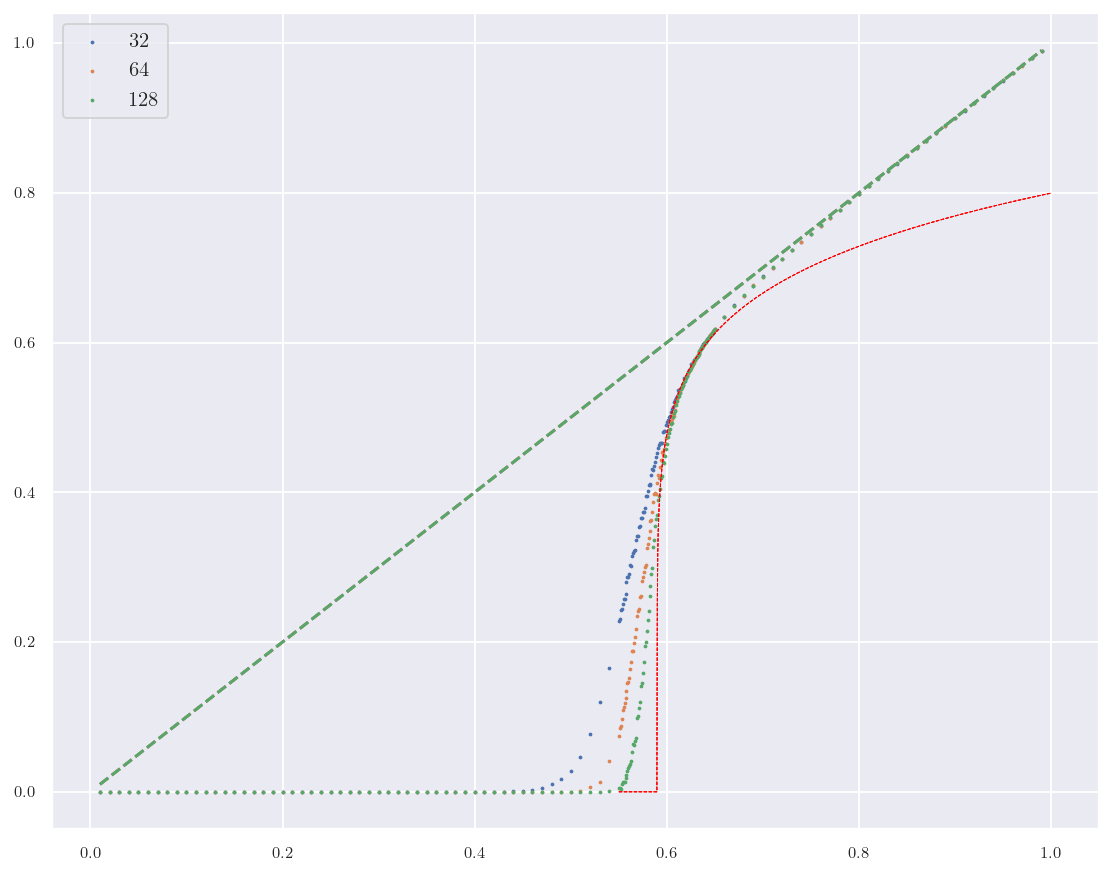

In [69]:
def get_plot_for_size(df):
    average_cluster_size_by_node = group_df[MEAN_CLUSTER_SIZE_COL].mean()
    
def fit_fn(X, a, p0, β):
    return np.heaviside(X - p0, 1) * a *np.abs(X - p0)**β

sizes = [32, 64, 128]
probabilities = []
df = filter_and_select_columns(df_orig, sizes, probabilities, [PERC_CLUSTER_STRENGTH_COL])
setup_figure()
for size, size_df in df.groupby(["size"]):
    
    prob_groups = size_df.groupby(["probability"])
    X = prob_groups["percolating_cluster_strength"].mean()
    plt.scatter(X.index, X, s=1, label=size)
    X_fit_range = [0.55, 1]
    X_fit = np.linspace(X_fit_range[0], X_fit_range[1], 1000)
    plt.plot(X.index, X.index, "--")
    
    plt.plot(X_fit, fit_fn(X_fit, 0.905, 0.59, 5/36), "--", color="red", linewidth=0.5)


plt.legend()
plt.show()
    

### Correlation function and correlation length


In [7]:
def get_correlation_function_from_prob_df(df, size):
    max_distance = 2 ** 0.5 * size # 2D specific!
    X, Y = get_average_dict_distribution(df, CORRELATION_FUNCTION_COL)
    X, Y = np.array(X), np.array(Y)
    X = X / N_BINS
    return X, Y

def fit_fn(X, a, b, c):
    return a*np.exp(-X/b) + c

def get_corr_function_exponential_fit(X, Y):
    assert(len(X) == len(Y))
    if len(X) < 5: # If there are few non-zero entries, assume 0 correlation length 
        return (0, 0, 0)

    X_filter = np.where(X > np.max(X)*0.5)
    X = X[X_filter]
    Y = Y[X_filter]
    try:
        popt, pcov = curve_fit(fit_fn, X, Y, p0=(1, 0.1, 0))
        if abs(popt[1]) > 0.4:
            
            return (0, 0, 0)
        return popt
    except Exception as e:
        return (0, 0, 0)
    
    
def get_corr_length(corr_X, corr_Y):
    if len(corr_X) < 10:
        return 0 
    
    max_distance = 2 ** 0.5 * size # 2D specific!
    distance = corr_X * max_distance 
    xi_squared = np.sum(np.multiply(distance ** 2, corr_Y)) / np.sum(corr_Y)
    return xi_squared ** 0.5


# Check why we have non-zero probability when x=0
sizes = [128]
probabilities = []
probabilities = [0.95]
probabilities = [p for p in df_orig['probability'].unique().tolist() if round(p, 3) == p]
# probabilities = [p for p in probabilities if p > 0.8]
print(probabilities)
df = filter_and_select_columns(df_orig, sizes, probabilities, [CORRELATION_FUNCTION_COL])
setup_figure()

fn = {}
leng = {}

for size, size_df in df.groupby([SIZE_COL]):

    X, Y = [], []
    for probability, prob_df in size_df.groupby([PROBABILITY_COL]):
        print(probability)
#         print(prob_df.shape)
        corr_X, corr_Y = get_correlation_function_from_prob_df(prob_df, size)
        fn[(probability, size)] = (corr_X, corr_Y)
#         popt = get_corr_function_exponential_fit(corr_X, corr_Y)
#         correlation_length = popt[1]

        correlation_length = get_corr_length(corr_X, corr_Y)
        leng[(probability, size)] = correlation_length
#         plt.scatter(corr_X, corr_Y, s=2, label=probability)
#         plt.plot(corr_X, fit_fn(corr_X, *popt), "--")
        
#         print(correlation_length)
#         print("---")
        X.append(probability)
        Y.append(correlation_length)
        
    
#     plt.scatter(X, Y, s=3, label=f"Data ($L=${size})")
# # plt.ylim([-0.01, 0.05])
# plt.title("Correlation length (2D square lattice)")
# plt.xlabel("Occupation probability $p$")
# plt.ylabel(r"Correlation length ($ \xi $)")
# plt.legend()
# plt.show()



[0.64, 0.72, 0.57, 0.45, 0.46, 0.49, 0.53, 0.54, 0.5, 0.47, 0.52, 0.56, 0.55, 0.59, 0.48, 0.63, 0.51, 0.58, 0.65, 0.6, 0.61, 0.68, 0.69, 0.66, 0.67, 0.73, 0.62, 0.7, 0.74, 0.71, 0.567, 0.595, 0.573, 0.618, 0.635, 0.629, 0.634, 0.601, 0.599, 0.582, 0.562, 0.603, 0.583, 0.563, 0.591, 0.552, 0.594, 0.626, 0.559, 0.577, 0.637, 0.597, 0.612, 0.561, 0.575, 0.592, 0.621, 0.647, 0.581, 0.593, 0.617, 0.642, 0.568, 0.614, 0.565, 0.564, 0.643, 0.644, 0.641, 0.566, 0.619, 0.605, 0.648, 0.638, 0.639, 0.646, 0.633, 0.584, 0.589, 0.596, 0.553, 0.623, 0.632, 0.588, 0.649, 0.645, 0.557, 0.631, 0.598, 0.586, 0.624, 0.608, 0.574, 0.613, 0.611, 0.572, 0.615, 0.628, 0.609, 0.607, 0.578, 0.616, 0.569, 0.555, 0.551, 0.558, 0.604, 0.622, 0.587, 0.576, 0.606, 0.554, 0.579, 0.585, 0.625, 0.556, 0.636, 0.627, 0.602, 0.571, 0.15, 0.28, 0.81, 0.11, 0.82, 0.91, 0.18, 0.17, 0.07, 0.35, 0.14, 0.3, 0.98, 0.08, 0.41, 0.27, 0.34, 0.37, 0.78, 0.86, 0.12, 0.84, 0.24, 0.2, 0.92, 0.79, 0.25, 0.01, 0.87, 0.42, 0.75, 0.02, 0.

<Figure size 1350x1080 with 0 Axes>

[-2.08333333e-01  2.14248163e-01  3.55751074e-01  1.44474848e-04]
[-2.08333333e-01  3.30443373e-01  3.36477572e-01  2.44470811e-04]
[-2.08333333e-01  3.11113583e-01  3.51691876e-01  2.85565156e-04]
[-2.08333333e-01  2.80889242e-01  3.83374328e-01  3.18380353e-04]
[-2.08333333e-01  2.86363408e-01  4.14220829e-01  2.33427125e-04]
[-2.08333333e-01  2.51707547e-01  4.54590429e-01  2.25707076e-04]
[-2.08333333e-01  2.74600904e-01  4.65405552e-01  3.16452254e-04]
[-2.08333333e-01  2.77572864e-01  4.86606542e-01  3.65637818e-04]
[-2.08333333e-01  2.60556568e-01  5.28941057e-01  3.53473068e-04]
[-2.08333333e-01  2.00857140e-01  6.33498527e-01  2.00649172e-04]
[-2.08333333e-01  2.48426586e-01  6.01615507e-01  2.73838662e-04]
[-2.08333333e-01  2.58072085e-01  6.25578646e-01  2.91424220e-04]
[-2.08333333e-01  2.53338208e-01  6.65239583e-01  3.18379012e-04]
[-2.08333333e-01  2.22440713e-01  7.54500020e-01  1.98680215e-04]
[-2.08333333e-01  2.19999269e-01  8.13743209e-01  2.00682714e-04]
[-2.083333

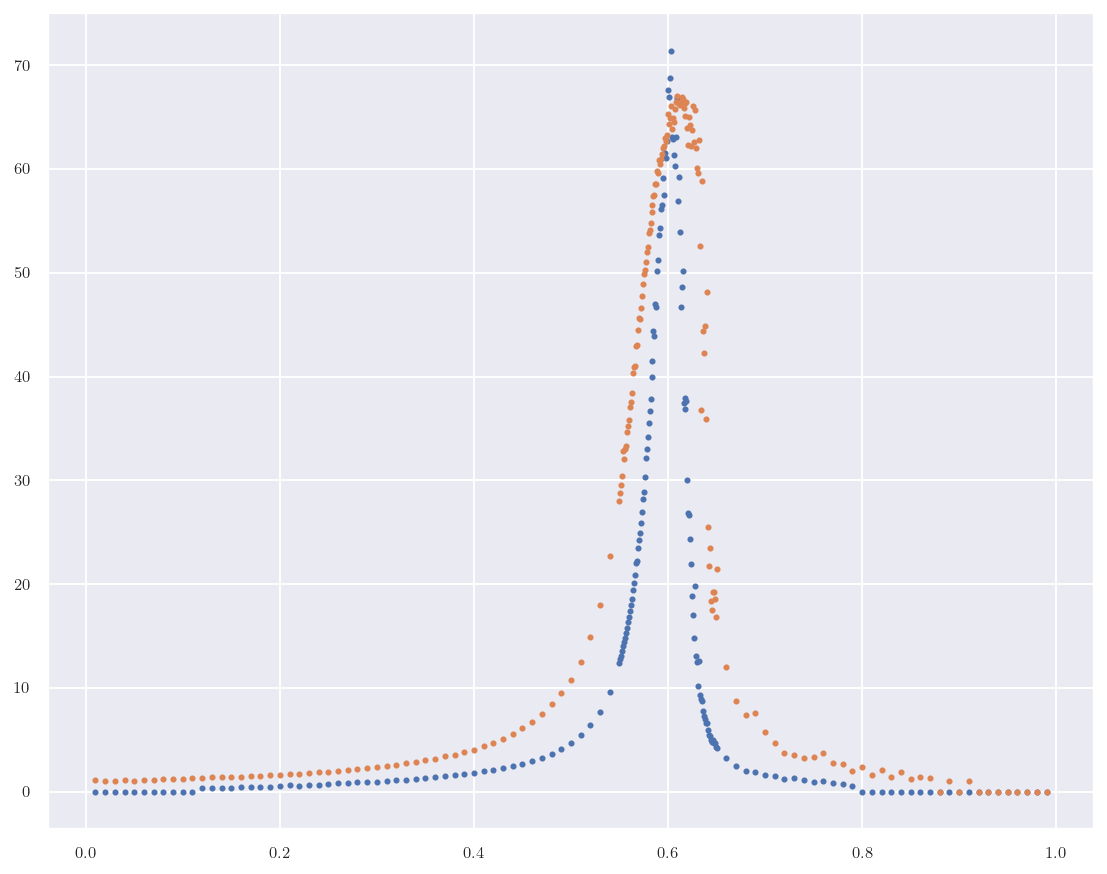

In [21]:
setup_figure()


# X, Y = [], []
# for k, v in leng.items():
#     p = k[0]
#     if 0.5 <= p <= 0.7:
#         X.append(k[0])
#         Y.append(v)
# plt.scatter(X, Y, s=5)

def fit_fn(X, d, a, b, c):
    return X**(-5/24) * a*np.exp(-X/b) + c 
    
    
X, Y, H = [], [], []
for k, v in fn.items():
    size = k[1]
    p = k[0]    
    fn_X = v[0]
    fn_Y = v[1]
    
    if 0.5 <= p <= 0.7:
        pass 
    max_distance = size * 2**0.5 
    
    if p == 0.59 or True:
#         print(fn_X*max_distance)
        fn_X = fn_X*max_distance
        if len(fn_X) < 10:
            popt = (0, 0, 0, 0)
        else:
            popt, _ = curve_fit(fit_fn, fn_X, fn_Y, p0=(-5/24, 1, 1, 0))
            print(popt)
#         plt.scatter(fn_X, fn_Y, s=2)
#         plt.plot(fn_X, fit_fn(fn_X, *popt), "--")
    
#     X.append(k[0])
#     Y.append(sum(fn_Y))
    X.append(p)
    
    Y.append(popt[2])
    if sum(fn_Y) == 0:
        H.append(0)
    else:
        H.append((sum([fn_X[i] ** 2 * fn_Y[i] for i in range(len(fn_X))])/sum(fn_Y))**0.5)
    
# plt.ylim([-3, 150])
plt.scatter(X, Y, s=5)
plt.scatter(X, H, s=5)
plt.show()

In [ ]:
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
# plt.axvline(probability)
import matplotlib.pyplot as plt
plot = PercolationProbabilityPlot()
for size, size_group in df.groupby(["size"]):
    X, Y, Y_errors = [], [], []
    for probability, prob_group in size_group.groupby(["probability"]):
        n_samples = len(prob_group)
        p_estimator = prob_group.mean()['has_percolated']
        
        X.append(probability)
        Y.append(p_estimator)
        z = 2.576
        error = z * (p_estimator * (1 - p_estimator)/n_samples)**0.5
        print(probability, p_estimator, n_samples)
        Y_errors.append(error) 
    
    plot.plot(X, Y, f"N={size}", fit_fn=tanh, err=Y_errors)
        
plot.save()